<a href="https://colab.research.google.com/github/jdomeneghini/Data_Science/blob/master/Detec%C3%A7aodeFraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Detecção de Fraude em Cartão de Crédito**

A clonagem de cartão de crédito é a fraude mais praticada da atualidade, de acordo com o Serviço de Proteção do Consumidor, gerando impactos financeiros consideráveis tanto para o consumidor quanto para as instituições financeiras. 

Diante disso, o investimento em áreas de detecção de fraude por meio de inteligência artificial vem crescendo a cada ano e a segurança nas operadoras de cartão está cada vez mais rigorosa.

O desafio deste projeto será trabalhar em cima de um dataset de grande volume, criando e testando um modelo para que possa prever e evitar possíveis transações fraudulentas.




### **Importandos os dados**

Os dados que usarei neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Ele contém apenas variáveis ​​de entrada numéricas que são os resultados de uma transformação PCA *(Principal Component Analysis)*, onde foram descaracterizados devido a questões de confidencialidade. As variáveis serão representadas por [V1, V2, V3..., V28].


In [12]:
#importanto bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')



#ocultar avisos
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
#lendo o dataset
df= pd.read_csv("https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1")



Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

### **Análise Exploratória**

Abaixo vamos visualizar as 5 primeiras entradas do dataset utilizando o comando *head* e também veremos um resumo estatistico, utilizando o comando describe.

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Com estas 5 entradas podemos tirar algumas conclusões:

- Pela trasnformação PCA que os dados sofreram, as features estão anônimas e os valores são todos numéricos.

- A variável *'Time'* e *'Amount'*  foram preservadas e manteram seu valor original.

- A variável *'Class'* é a variável de resposta e assume o valor de:
  *   **1**: fraude
  *   **0**: transação normal


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Analisando brevemente este resumo estatístico conseguimos ver que aparentemente não tem nenhuma discrepância entre os dados. 

É importante também verificar se o dataset possui valores ausentes, quando presentes é preciso analisá-los pois eles podem afetar as estatísticas dos dados.


In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Neste caso, o dataset não possuem dados ausentes.


Como informado acima, as entradas relativas a fraudes correspondem a 0,17% do total. Assim irei plotar um gráfico para verificarmos como ficará este valor na distribuição da nossa variável 'Class'. 

0    284315
1       492
Name: Class, dtype: int64

Quantos % as fraudes representam no dataset: 0.1727%



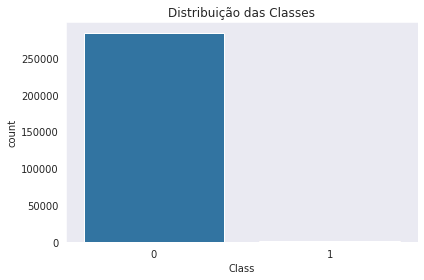

In [ ]:
#grafico de barras para verificar a distribuição das Classes

fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.tight_layout();


print(df.Class.value_counts())
print('\nQuantos % as fraudes representam no dataset: {:.4f}%\n'.format(df[df.Class ==1].shape[0]/ df.shape[0] * 100))



Através deste gráfico se torna nítida a discrepância entre as entradas dos dados. Na prática isso interfere no desempenho do modelo e será necessário fazer um balanceamento dos dados antes de partir para criação do modelo de classificação. 

O gráfico abaixo mostrará os segundo decorridos entre as transações normais e as transações onde ocorreram as fraudes.


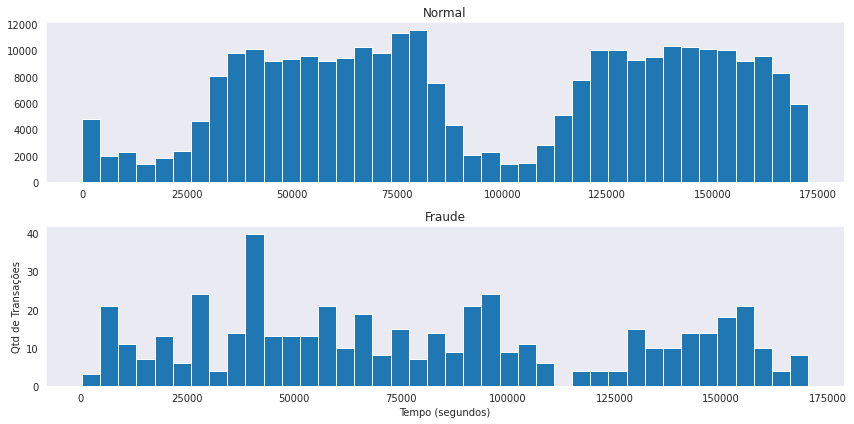

In [ ]:
#grafico de barras para verificar a distribuição da variavel time x classe

fig, ax= plt.subplots(nrows=2, ncols=1, figsize=(12,6))
num_bins= 40
ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(df.Time[df.Class == 1], bins= num_bins)
ax[1].set_title('Fraude')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Qtd de Transações')
plt.tight_layout();

Nenhuma informação relevante diante desta distribuição de frequência.

Seguindo para a variável *'Amount'*, irei gerar um gráfico boxplot para notarmos diferenças no padrão entre as transações.

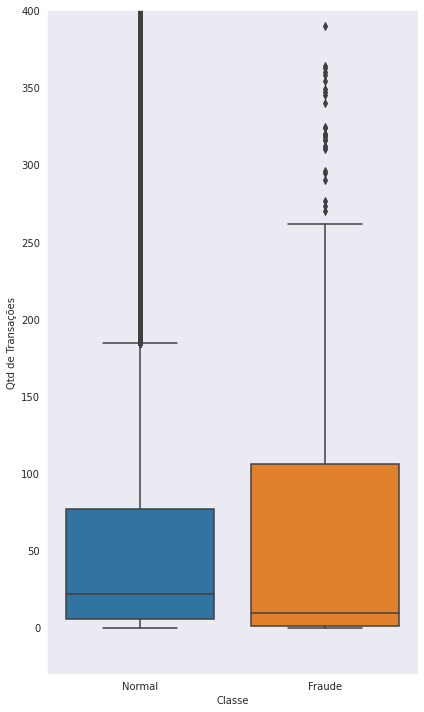

In [ ]:
#boxplot para variavel Amount
fig, ax= plt.subplots(figsize=(6,10))

sns.boxplot(df.Class, df.Amount, ax=ax)
plt.ylim((-30, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.xlabel('Classe')
plt.ylabel('Qtd de Transações')
plt.tight_layout();

O boxplot nos mostra uma distribuição bem diferente entre as duas classes.

Para entedermos melhor a classe que representa as transações de fraude, vamos verificar algumas informações estatísticas:

In [ ]:
df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].describe()

count     491.000000
mean      118.130550
std       240.439028
min         0.000000
25%         1.000000
50%         9.210000
75%       105.350000
max      1809.680000
Name: Amount, dtype: float64

Nota-se que a classe possui média de 118 e uma mediana de 9.

Um outro gráfico muito interessante para detectar algumas anomalias entre variávies é o de densidade. Nele podemos verificar as distribuições de cada variável para cada classe, identificando fraudes mais facilmente. 


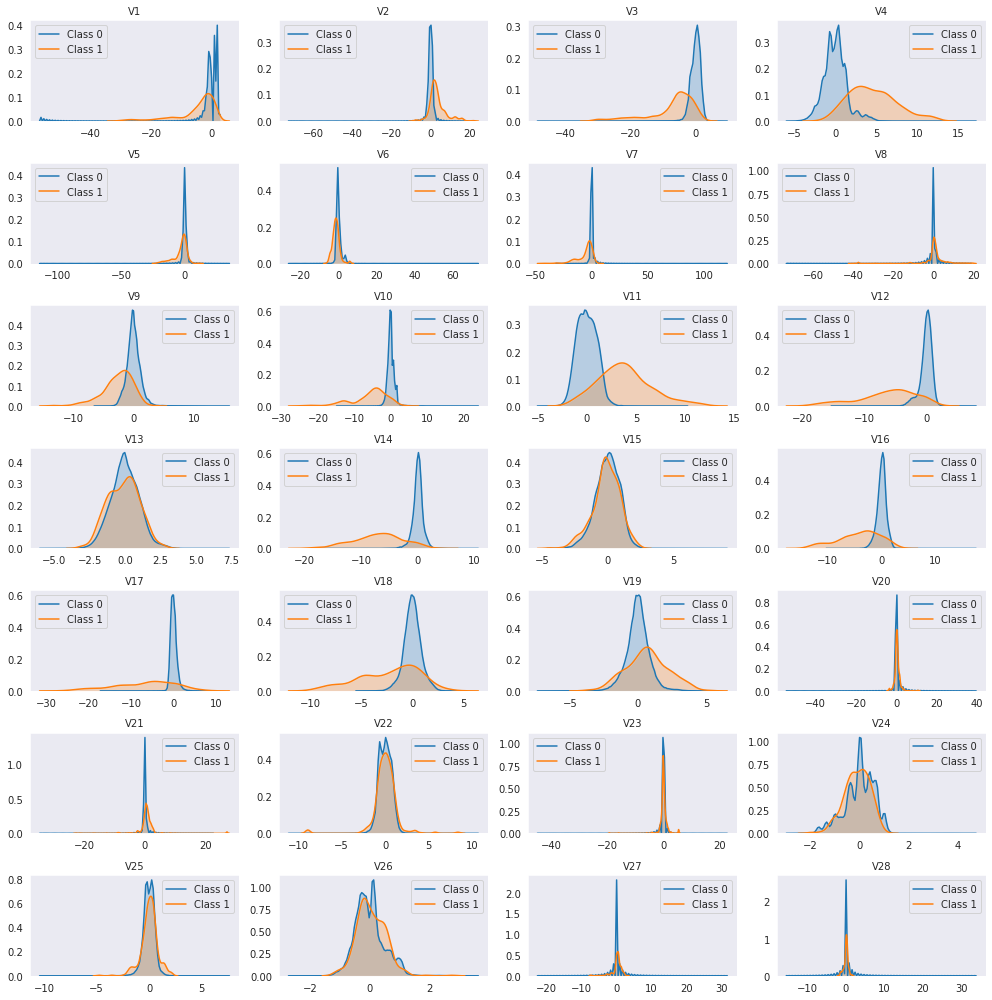

In [ ]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis = 1).columns 
num_plots= len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(14,14))
fig.subplots_adjust(hspace= 1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()
 


Podemos identificar similaridades em algumas variáveis, como por exemplo a *V8* e *V23*, entre outras.
E também muitas anomalias, como *V4* e V11, entre outras.




***Considerações finais sobre esta análise:***

- O dataset está muito desbalanceado, pelo fato de as transações fraudulentas representarem somente 0,17% das entradas totais.
- Não existem valores nulos ou ausentes no dataframe.
- Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as *features* originais foram padronizadas.
* As colunas *'Time'* e *'Amount'* não estão normalizadas.


### **Preparando os dados**

Para poder criar um modelo de Machine Learning precisarei preparar os dados.
Nesta etapa irei:
- Padronizar as features *'Time'* e *'Amount'*, que estão em ordem de grandeza.
- Dividir entre dados de treino e teste.
- Balancear os dados a fim de evitar uma baixa performance para a classe de fraude e *overfitting*.

**Padronizando** *'**Time**'* e *'**Amount**'*

In [3]:
# padronizar as colunas Time e Amount
df_clean = df.copy()

std_scaler= StandardScaler()
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1,1))
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1,1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace= True)

#ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_time,std_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403


**Dividindo os dados para treino e teste**

Antes de fazer os balanceamento de dados, devemos splitar os dados já existentes entre treino e teste. Caso contrário, não teremos parâmetros para conferir se o balanceamento foi adequado.

Para garantir que os conjuntos de treino e teste tenham a mesma quantidade de classes proporcionalmente, utilizamos o parâmetro *'stratify=True'*.

In [4]:
#determinando x e y
x= df_clean.drop('Class', axis=1)
y= df.Class

#dividindo o dataset em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, shuffle=True) 


**Balanceando os dados**

Utilizarei o método do *Under-Sampling*, que basicamente vai eliminar entradas da classe majoritária aleatoriamente para que possa equalizar com as entradas minoritárias.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    369
0    369
dtype: int64


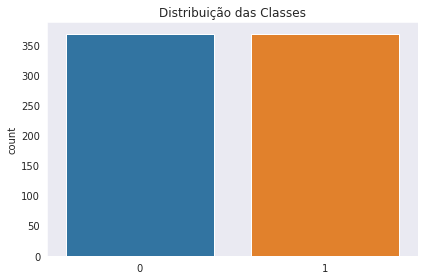

In [5]:
#chamando o metodo
rus = RandomUnderSampler()
x_rus, y_rus = rus.fit_sample(x_train, y_train)

#grafico da nova distribuição de classes
fig, ax = plt.subplots()
sns.countplot(y_rus, ax=ax)
ax.set_title('Distribuição das Classes')
plt.tight_layout();

#print do balanceamento
print(pd.Series(y_rus).value_counts())



Após a etapa de balanceamento farei uma matriz de correlação para identificarmos quais variáveis se relacionam mais fortemente.
Também irei comparar com a matriz de correlação dos dados desbalanceados.


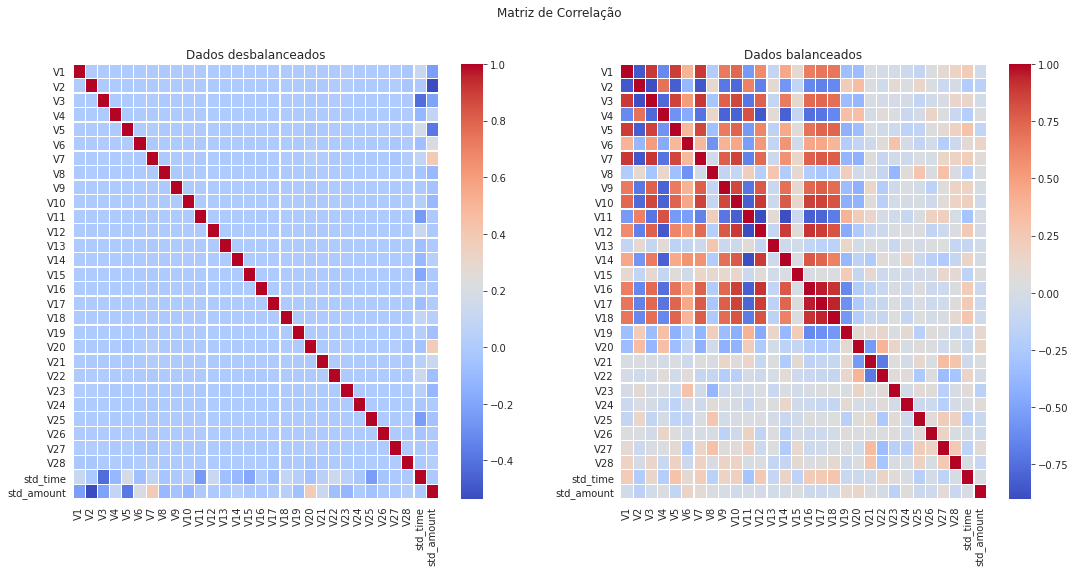

In [16]:
#plotando a matriz de correlação
corr= x_train.corr()
corr_rus= pd.DataFrame(x_rus).corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (18,8))
fig.suptitle("Matriz de Correlação")

sns.heatmap(corr, xticklabels= corr.columns, yticklabels=corr.columns, linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Dados desbalanceados")

sns.heatmap(corr_rus, xticklabels= corr.columns, yticklabels=corr.columns, linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Dados balanceados")

plt.show()

A diferença das duas matrizes são bem notáveis. E então podemos ver que com os dados balanceados, as variáveis apresentam maiores relevâncias entre elas.
Terminando essa etapa, podemos construir o modelo.

### **Construção do Modelo de Machine Learning**

Com os dados preparados, analisados e balanceados, irei construir um modelo de classificação usando a Regressão Logística.



In [ ]:
#criando o modelo
np.random.seed(2)
model= LogisticRegression()
model.fit(x_rus, y_rus)

y_pred= model.predict(x_test)
y_prob= model.predict_proba(x_test)

Após a criação do modelo e as previsões feitas, irei avaliar o desempenho do modelo usando algumas métricas.

Para este caso a acurácia não é uma métrica adequada devido ao problema do desbalanceamento, a mais eficaz neste sentido seria a AUC ROC (área sobre a curva).

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9577    0.9783     71079
           1     0.0363    0.9187    0.0698       123

    accuracy                         0.9577     71202
   macro avg     0.5181    0.9382    0.5240     71202
weighted avg     0.9982    0.9577    0.9768     71202

Acurácia: 0.9577

AUC ROC: 0.9382



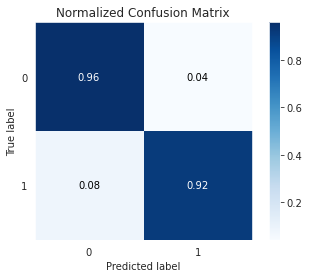

In [ ]:
#matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True);

#imprimir relatorio de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

#imprimir a acuracia
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

#imprimir a área sobre a curva
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))


### **Considerações Finais**

Com este projeto podemos identificar que mesmo com os diversos problemas enfrentados neste dataframe, como os dados desbalanceados e a transformação PCA é possivel conseguir resultados positivos, com um modelo apresentando um bom desempenho.

Ainda assim, é possível utilizar outros algoritmos de classificação afim de alcançar melhores resultados.